In [1]:
import pystac
items = pystac.ItemCollection.from_file('rhodes_sentinel-2.json')

In [2]:
item = items[0]

In [3]:
visual_href = item.assets['visual'].href

In [4]:
import rioxarray
visual = rioxarray.open_rasterio(visual_href, overview_level=1)
visual

<xarray.DataArray (band: 3, y: 2745, x: 2745)>
[22605075 values with dtype=uint8]
Coordinates:
  * band         (band) int64 1 2 3
  * x            (x) float64 5e+05 5e+05 5.001e+05 ... 6.097e+05 6.098e+05
  * y            (y) float64 4.1e+06 4.1e+06 4.1e+06 ... 3.99e+06 3.99e+06
    spatial_ref  int64 0
Attributes:
    AREA_OR_POINT:       Area
    OVR_RESAMPLING_ALG:  AVERAGE
    _FillValue:          0
    scale_factor:        1.0
    add_offset:          0.0

## Crop by bounding box

In [5]:
import geopandas as gpd
gdf_rhodes = gpd.read_file('rhodes.gpkg')

In [6]:
gdf_rhodes.crs.to_epsg()

4326

In [7]:
visual.rio.crs.to_epsg()

32635

In [8]:
gdf_rhodes = gdf_rhodes.to_crs(visual.rio.crs)

In [9]:
gdf_rhodes.total_bounds

array([ 561505.80329814, 3970451.33353859,  611872.89042946,
       4035463.69404871])

In [10]:
visual_clipbox = visual.rio.clip_box(*gdf_rhodes.total_bounds)
visual_clipbox

<xarray.DataArray (band: 3, y: 1131, x: 1207)>
[4095351 values with dtype=uint8]
Coordinates:
  * band         (band) int64 1 2 3
  * x            (x) float64 5.615e+05 5.616e+05 ... 6.097e+05 6.098e+05
  * y            (y) float64 4.035e+06 4.035e+06 4.035e+06 ... 3.99e+06 3.99e+06
    spatial_ref  int64 0
Attributes:
    AREA_OR_POINT:       Area
    OVR_RESAMPLING_ALG:  AVERAGE
    scale_factor:        1.0
    add_offset:          0.0
    _FillValue:          0

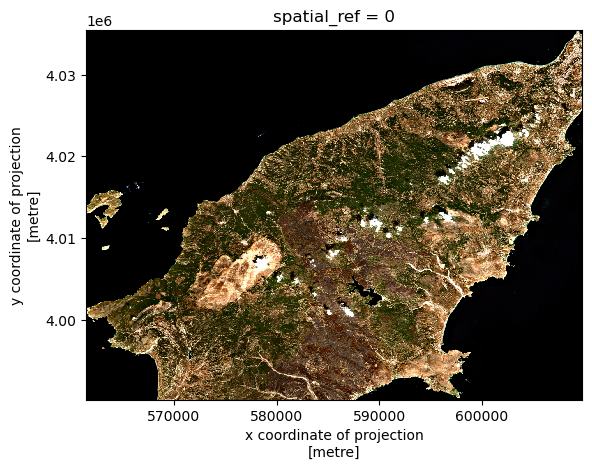

In [11]:
visual_clipbox.plot.imshow()

## Crop by a GeoDataFrame

In [12]:
visual_clip = visual_clipbox.rio.clip(gdf_rhodes['geometry'])
visual_clip

<xarray.DataArray (band: 3, y: 1131, x: 1207)>
array([[[0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        ...,
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0]],

       [[0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        ...,
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0]],

       [[0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        ...,
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0]]], dtype=uint8)
Coordinates:
  * band         (band) int64 1 2 3
  * x            (x) float64 5.615e+05 5.616e+05 ... 6.097e+05 6.098e+05
  * y            (y) float64 4.035e+06 4.035e+06 4.035e+06 ... 3.99e+06 3.99e+06
    spatial_ref  int64 0
Attributes:
    AREA_OR_POINT:       Area
    OVR_RESAMPLING_ALG:  AVERAGE
    scale_factor:        1.0
    add_offset:          0.0
    _FillValue:          0

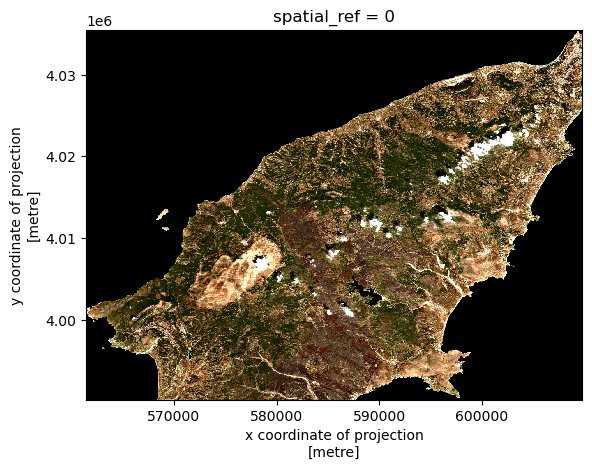

In [13]:
visual_clip.plot.imshow()

## Match two rasters in different CRS and resolution

In [14]:
dem = rioxarray.open_rasterio('./data/dem/rhodes.tif')
dem

<xarray.DataArray (band: 1, y: 2098, x: 2029)>
[4256842 values with dtype=float32]
Coordinates:
  * band         (band) int64 1
  * x            (x) float64 27.68 27.68 27.68 27.68 ... 28.25 28.25 28.25 28.25
  * y            (y) float64 36.46 36.46 36.46 36.46 ... 35.88 35.88 35.88 35.88
    spatial_ref  int64 0
Attributes:
    AREA_OR_POINT:  Point
    _FillValue:     nan
    scale_factor:   1.0
    add_offset:     0.0

In [15]:
dem.rio.crs

CRS.from_epsg(4326)

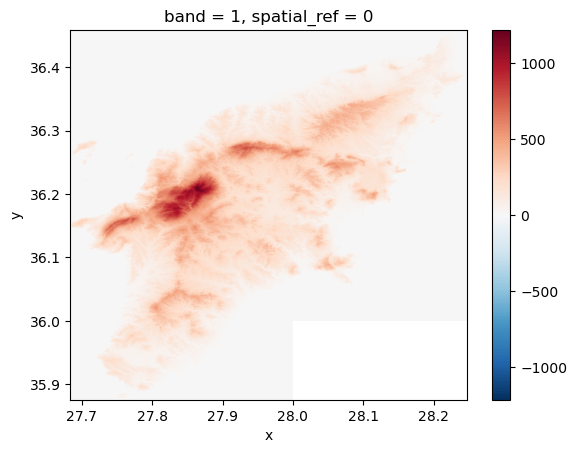

In [16]:
dem.plot()

In [17]:
dem_match = dem.rio.reproject_match(visual_clip)

In [18]:
dem_match

<xarray.DataArray (band: 1, y: 1131, x: 1207)>
array([[[nan, nan, nan, ...,  0.,  0.,  0.],
        [nan, nan, nan, ...,  0.,  0.,  0.],
        [nan, nan, nan, ...,  0.,  0.,  0.],
        ...,
        [nan, nan,  0., ...,  0.,  0.,  0.],
        [nan, nan,  0., ...,  0.,  0.,  0.],
        [nan, nan,  0., ...,  0.,  0.,  0.]]], dtype=float32)
Coordinates:
  * band         (band) int64 1
    spatial_ref  int64 0
  * x            (x) float64 5.615e+05 5.616e+05 ... 6.097e+05 6.098e+05
  * y            (y) float64 4.035e+06 4.035e+06 4.035e+06 ... 3.99e+06 3.99e+06
Attributes:
    AREA_OR_POINT:  Point
    scale_factor:   1.0
    add_offset:     0.0
    _FillValue:     nan

In [19]:
dem_match

<xarray.DataArray (band: 1, y: 1131, x: 1207)>
array([[[nan, nan, nan, ...,  0.,  0.,  0.],
        [nan, nan, nan, ...,  0.,  0.,  0.],
        [nan, nan, nan, ...,  0.,  0.,  0.],
        ...,
        [nan, nan,  0., ...,  0.,  0.,  0.],
        [nan, nan,  0., ...,  0.,  0.,  0.],
        [nan, nan,  0., ...,  0.,  0.,  0.]]], dtype=float32)
Coordinates:
  * band         (band) int64 1
    spatial_ref  int64 0
  * x            (x) float64 5.615e+05 5.616e+05 ... 6.097e+05 6.098e+05
  * y            (y) float64 4.035e+06 4.035e+06 4.035e+06 ... 3.99e+06 3.99e+06
Attributes:
    AREA_OR_POINT:  Point
    scale_factor:   1.0
    add_offset:     0.0
    _FillValue:     nan

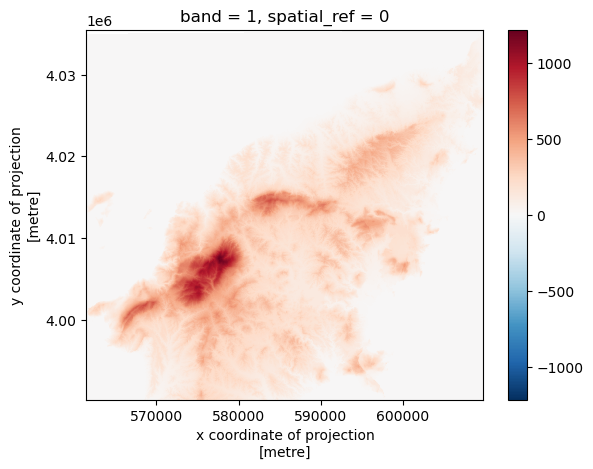

In [20]:
dem_match.plot()

In [21]:
dem_match.rio.to_raster('dem_rhodes_match.tif', driver='COG')